# BUSINESS UNDERSTANDING

## Introduction
###### Predict forest fire using meteorological data

# DATA MINING

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action = 'ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score ,mean_squared_error

In [2]:
#use this code to be able to display all the output in the cell instead of only displaying the out put for the last one. see the next cell.
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"


##### Dataset:
The dataset(https://archive.ics.uci.edu/ml/datasets/Forest+Fires) covers meteorological and spatiotemporal data for forest fires (between 2000 and 2003) in Portugal’s Montesinho Natural Park, with 517 incidents & 13 attributes which are :<br>

Location of incident:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9. 
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9 <br>
Date the incident happened:<br>
3. month - month of the year: 'jan' to 'dec' 
4. day - day of the week: 'mon' to 'sun'<br>
Canadian Forest Fire Weather Index (FWI):Measures the effects of fuel moisture and wind on fire behavior<br>
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20 
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10<br> 
Meteorological:<br>
9. temp - temperature in Celsius degrees: 2.2 to 33.30 
10. RH - relative humidity in %: 15.0 to 100 <br>
11. wind - wind speed in km/h: 0.40 to 9.40 <br>
12. rain - outside rain in mm/m2 : 0.0 to 6.4 <br>
Area burnt:
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 <br>


In [3]:
df = pd.read_csv('forestfires.csv')

In [4]:
df.head()
df.shape

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


(517, 13)

# DATA CLEANING

In [5]:
#use this code to be able to display all the output in the cell instead of only displaying the out put for the last one. see the next cell.
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

In [6]:
from pandas_profiling import ProfileReport
corr_list = ['DC','temp']
df_profile = ProfileReport(df, correlation_threshold= 0.4, correlation_overrides = corr_list)
df_profile

Number of variables,13
Number of observations,517
Total Missing (%),0.0%
Total size in memory,52.6 KiB
Average record size in memory,104.2 B
Numeric,9
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,2


## pandas profiling

In [7]:
df_profile

Number of variables,13
Number of observations,517
Total Missing (%),0.0%
Total size in memory,52.6 KiB
Average record size in memory,104.2 B
Numeric,9
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,2


In [69]:
#profile.to_file(output_file="your_report.html")

###### From the profile report we learn these:
1.The data has no missing values but we have 4 duplicates and we will remove the duplicate values.<br> 
2.In 99% of the fire incidents there was no rain. <br>
3.The month and day features are the only categorical features and the the rest are continuous.<br>
4.Most of the fires are small fires with 45% of them less than a hectare. because of these our target variable 'area' is skewed to the right and we need to log transform.<br>
5.Most of the fires occurred between Friday & Sunday with Sunday being the highest and month of August and September, August being the highest<br>


###### Remove duplicates

In [ ]:
print ('Data length before removing duplicates is ' ,len(df))
df.drop_duplicates(keep= "first", inplace = True) # to delete only the duplicated(4) ones.if keep = false it will delete 8 of them  
print ('Data length after removing duplicates is ' ,len(df))

# DATA EXPLORATION & VISUALIZATION

## UNIVARIATE ANALYSIS
we will try to analyze each feature.

### AREA
Area is the burnt are in hectares and it is our target variable. 

In [9]:
df['area'].plot(kind= 'hist')
sns.kdeplot(df['area'])

Area is not normally distributed and it is skewed to the left with majority of them 0.we will try to log transform to fix this.

In [10]:
df['log_area']= np.log(df['area']+1)
sns.kdeplot(df['log_area'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [11]:
large_fire_df = df.query('area > 0')
large_fire_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36,0.307485
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43,0.357674
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47,0.385262
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55,0.438255
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61,0.476234


  ### RAIN

From the or profiling report we learned that it was not raining on 99% of the fires. Let's try to see how rain affects the size of the area.

In [12]:
rain_df = df.query('rain > 0') # create a dataframe for only rainy days
rain_df.shape

(8, 14)

In [13]:
rain_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000
243,7,4,aug,sun,91.8,175.1,700.7,13.8,21.9,73,7.6,1.0,0.00,0.000000
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00,0.000000
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82,2.469793
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,0.000000
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,0.000000
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00,0.000000
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,1.153732


###### Most of the rainy days the burnt area is very small( less than a hectare). the times with large area is in August and all the variables in their maximum range.

### MONTH

Is there a specific month or data that the area is high? let's see the stripplot with box plot 

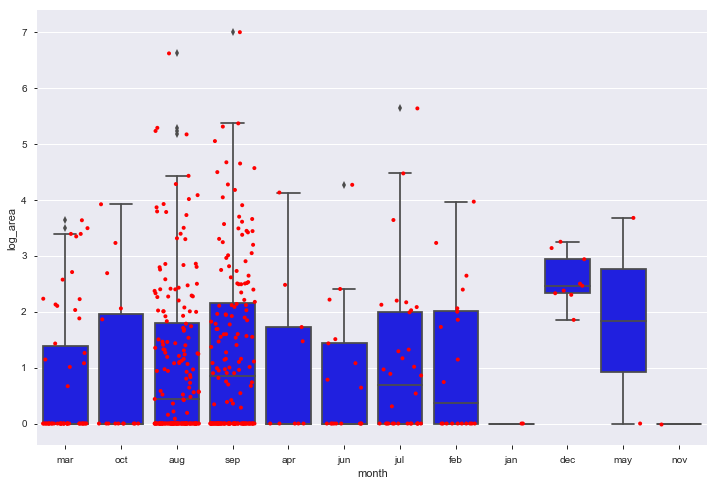

In [72]:
ax= plt.figure(figsize =(12,8))
ax = sns.boxplot(x='month',y='log_area', data =df, color= 'blue' )
ax = sns.stripplot(x='month',y='log_area', data =df, color= 'red', jitter=0.4, size=4 )
plt.show()

###### Majority of the fires are in August & September.Few incidents happened in December  but the area is to the highest side.

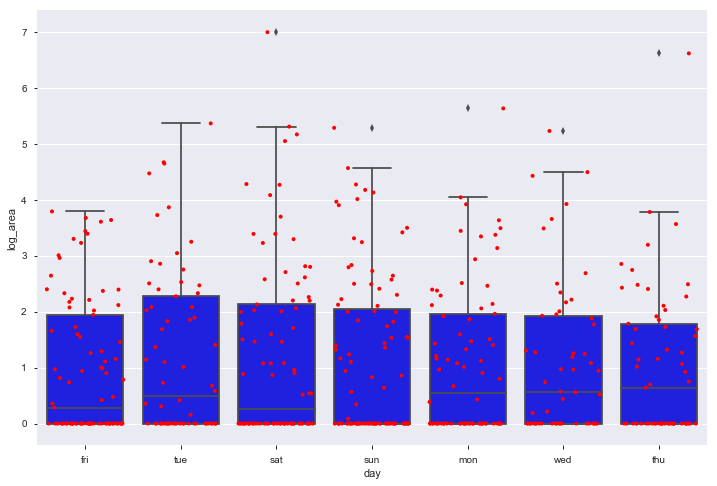

In [73]:
ax= plt.figure(figsize =(12,8))
ax = sns.boxplot(x='day',y='log_area', data =df, color= 'blue' )
ax = sns.stripplot(x='day',y='log_area', data =df, color= 'red', jitter=0.4, size=4 )
plt.show()

### TEMPRATURE

## MULIIVARIATE ANALYSIS

#### Checking for distribution

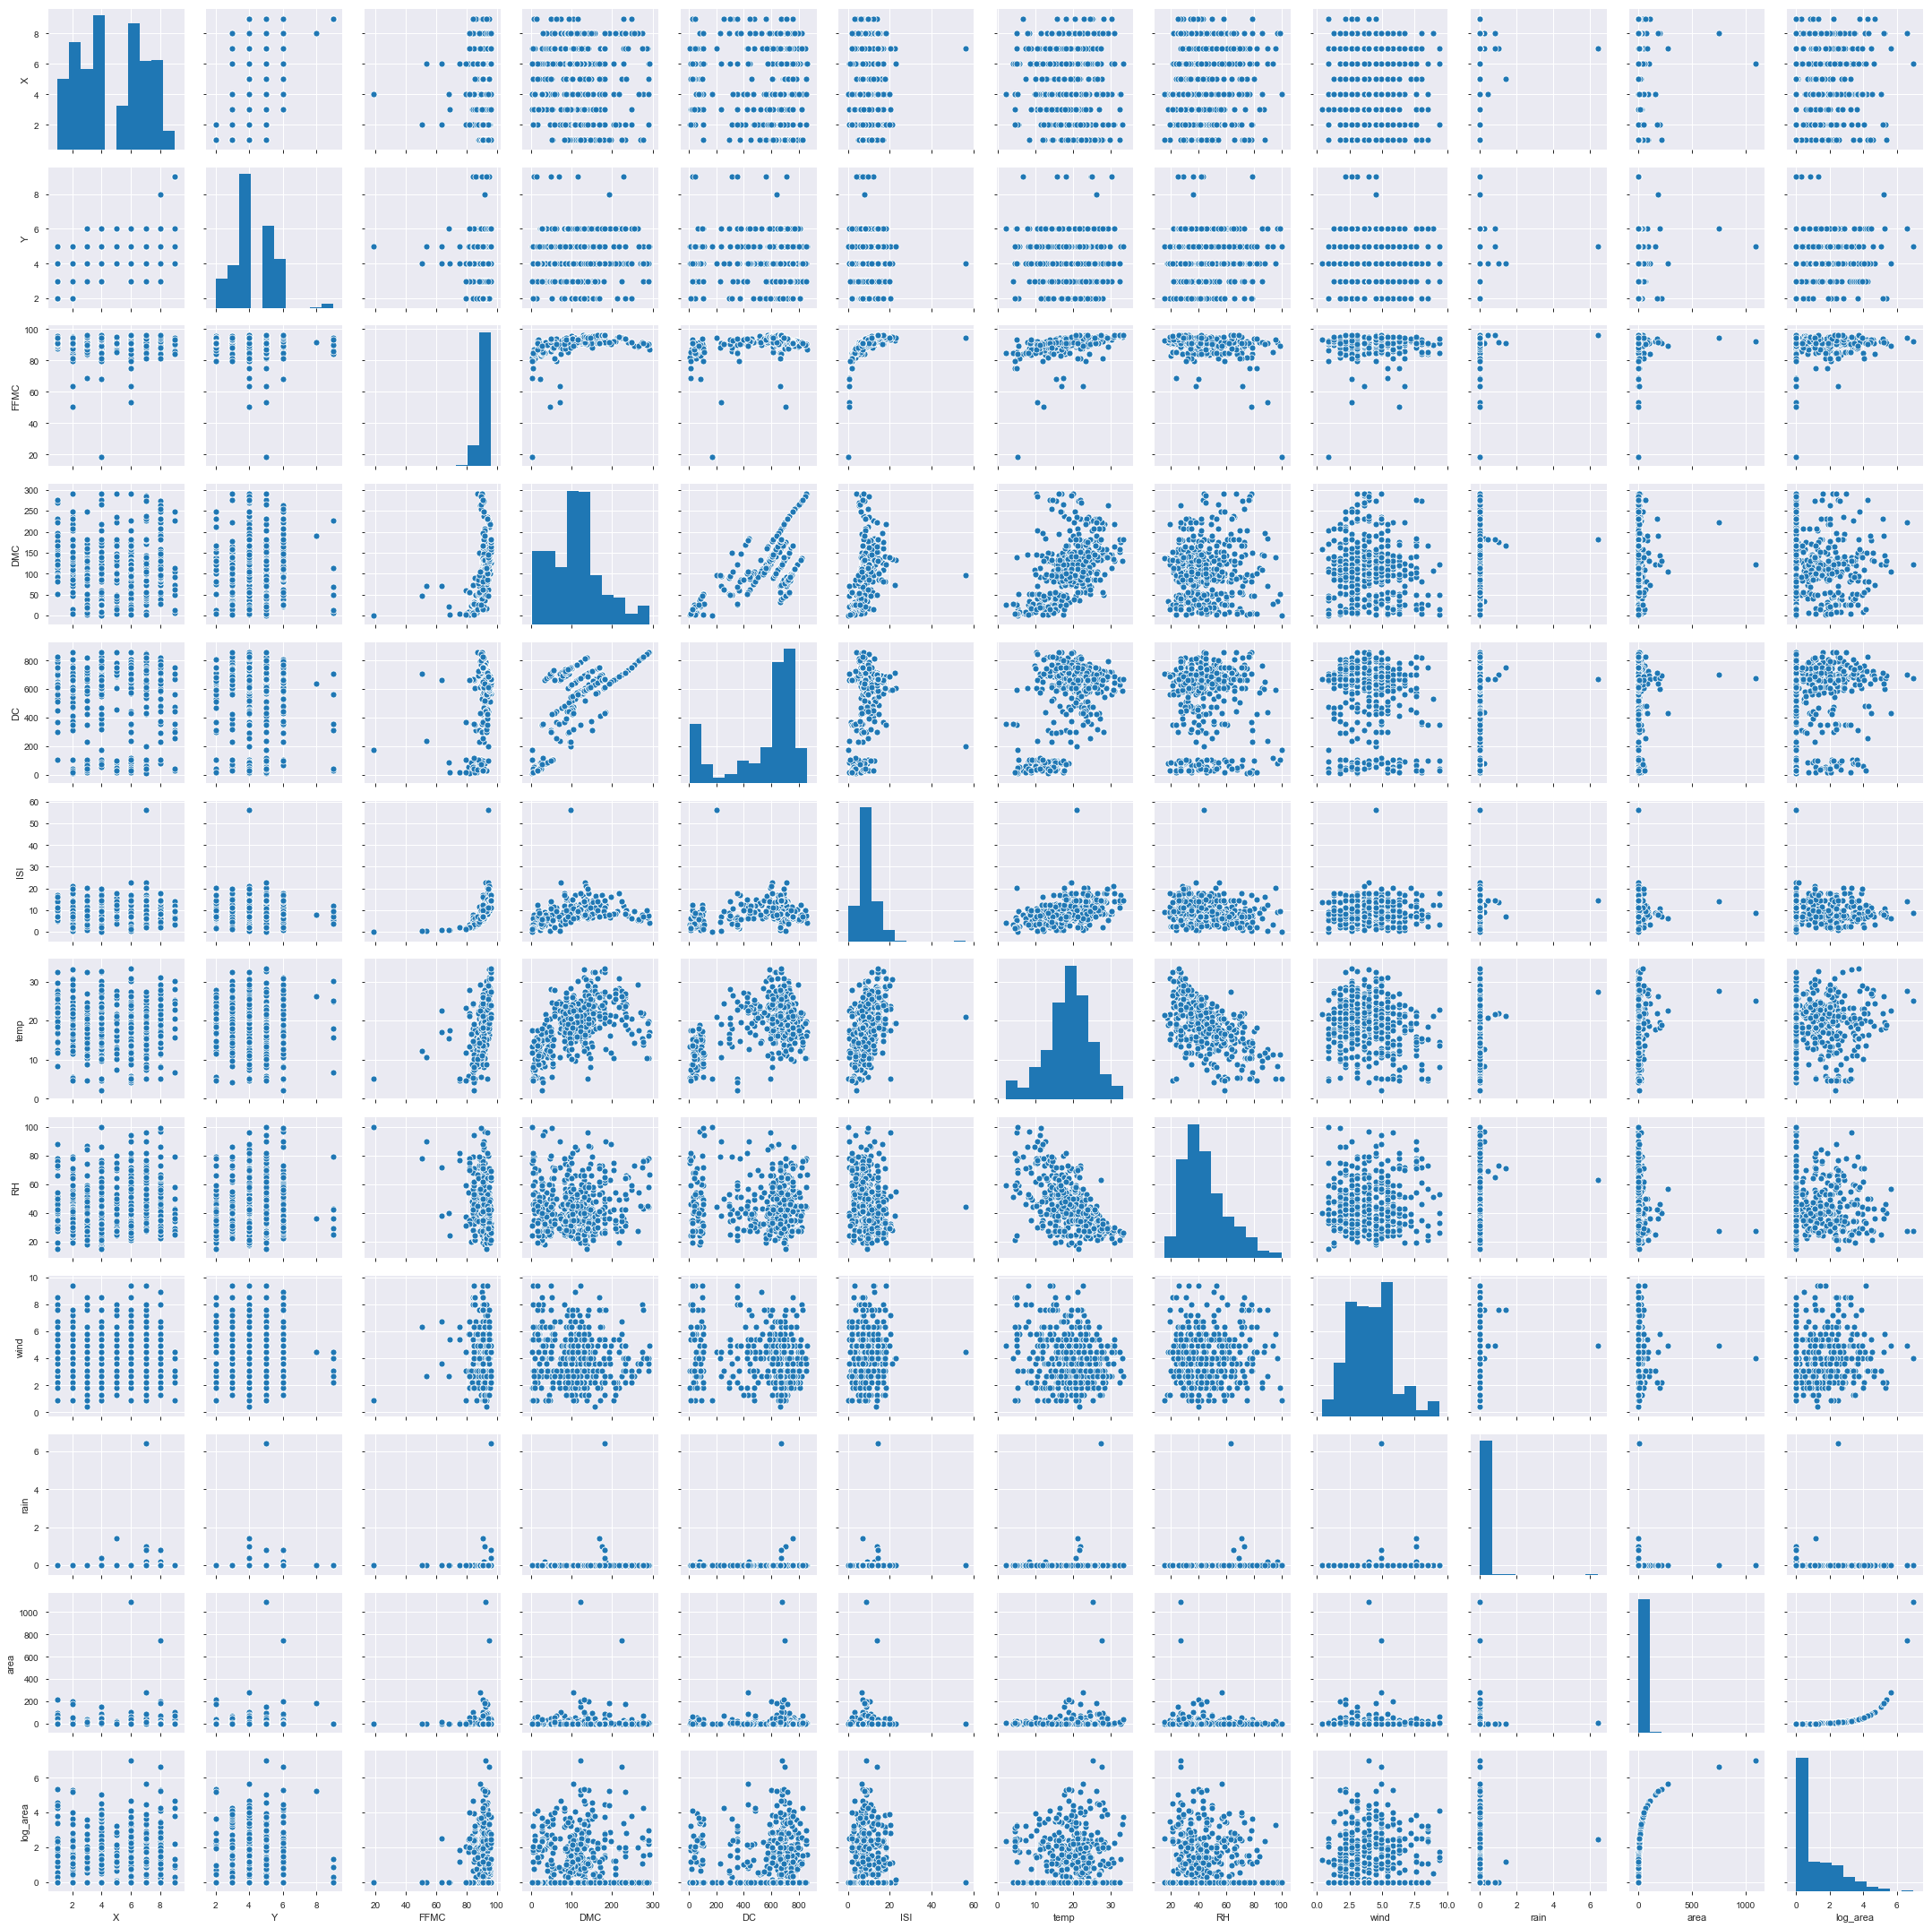

In [74]:
sns.pairplot(df)
plt.show()

Except temperature all the other features are not following the normal distribution and none of the features show linearity with area.Linearity between the target and the features is one of the linear regression assumption. since it is not satisfied we can't do linear regression. 

#### Correlation

In [17]:
fig, ax = plt.subplots(figsize = (18, 20)) # to make the heatmap bigger
sns.heatmap(df.corr(),center=0, annot=True, annot_kws={"size":10});

###### Here is how the correlation looks like:<br>
DC and DMC (0.68)<br>
X and Y (0.54)
FFMC and ISC (0.53) <br>
Temp & RH negatively correlated(-0.53)<br>
In general the FWI measures(FFMC,ISC, DC & DMC)are positively correlated with Temperature. 





# FEATURE ENGINEERING

In [18]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0


Before We start modeling, we need to transform the categorical to numerical by using the pandas get_dummy function variable 

In [19]:
df_dummy = pd.get_dummies(df,columns=['day','month'],drop_first=True)
df_dummy.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,1,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,1,0,0,0,0


Our target variable is area and we will use different features to sort out the best predictive variables.<br>
feature_all: using all attributes<br>
feature_w :using only the four weather conditions<br>  
feature_f: using only the four FWI components<br>
feature_ws:all attributes except FWI components<br>


In [20]:
feature_all= df_dummy.drop((['area','log_area']), axis=1) # using all attributes
feature_w = df[['temp','RH','wind','rain']] # using only the four weather conditions 
feature_f = df[['FFMC','DMC','DC','ISI']] #using only the four FWI components
feature_ws = feature_all.drop((['FFMC','DMC','DC','ISI']), axis=1)  #all attributes except FWI components
# target variable
y =df_dummy['area']
# target variable log transform
y_log= df_dummy['log_area']

To make the code less repetitive I will use the following function. It inputs the model & the data frame (different features). then it will split the data to train and test set, fit the model and calculate & print the  mean squared error. 

In [21]:
def reg_models(model ,df):
    x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    rsquared_train = r2_score(y_train,pred_train)
    print('The train root mean squared error is:', rmse_train)
    print('The test root mean squared error is:', rmse_test)
    print('The train R squared score is:', rsquared_train)

# PREDICTIVE MODELING

 ## Using all the attributes as feature variables

In [22]:
reg_models(RandomForestRegressor(),feature_all)

The train root mean squared error is: 24.649335975121033
The test root mean squared error is: 91.56776678113644
The train R squared score is: 0.741472353151386


In [23]:
from sklearn.svm import SVR
SVR(kernel='linear')
reg_models(SVR(),feature_all)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

The train root mean squared error is: 49.475908087934116
The test root mean squared error is: 90.31588601503395
The train R squared score is: -0.04155951946284642


In [24]:
from sklearn.linear_model import LinearRegression
reg_models(LinearRegression(),feature_all)

The train root mean squared error is: 47.13980927749124
The test root mean squared error is: 88.49005048187827
The train R squared score is: 0.05447680617785389


In [25]:
from sklearn.tree import DecisionTreeRegressor
reg_models(DecisionTreeRegressor(),feature_all)

The train root mean squared error is: 0.35876249290552864
The test root mean squared error is: 102.10513372035356
The train R squared score is: 0.999945234051882


 ## Using only the four weather conditions

In [26]:
reg_models(RandomForestRegressor(),feature_w)

The train root mean squared error is: 18.761708783732335
The test root mean squared error is: 92.02917922474612
The train R squared score is: 0.8502243111397553


In [27]:
reg_models(SVR(),feature_w)

The train root mean squared error is: 49.483577499669906
The test root mean squared error is: 90.31998867526508
The train R squared score is: -0.0418824551398056


In [28]:
reg_models(LinearRegression(),feature_w)

The train root mean squared error is: 48.13239007702705
The test root mean squared error is: 88.9051159427622
The train R squared score is: 0.014239527081620351


In [29]:
reg_models(DecisionTreeRegressor(),feature_w)

The train root mean squared error is: 3.7104931565023267
The test root mean squared error is: 95.75453610919898
The train R squared score is: 0.9941418590839891


 ## Using only the four FWI components

In [30]:
reg_models(RandomForestRegressor(),feature_f)

The train root mean squared error is: 40.68429807882609
The test root mean squared error is: 81.48294897891141
The train R squared score is: 0.29571214457357864


In [31]:
reg_models(SVR(),feature_f)

The train root mean squared error is: 49.61132881653439
The test root mean squared error is: 90.18014801805006
The train R squared score is: -0.047269036965184696


In [32]:
reg_models(LinearRegression(),feature_f)

The train root mean squared error is: 48.08089113830138
The test root mean squared error is: 89.42892512587254
The train R squared score is: 0.01634781465843771


In [33]:
reg_models(DecisionTreeRegressor(),feature_f)

The train root mean squared error is: 39.201607507991206
The test root mean squared error is: 83.99664704453103
The train R squared score is: 0.34611060071060595


## Using all attributes except FWI components

In [34]:
reg_models(RandomForestRegressor(),feature_ws)

The train root mean squared error is: 27.685030701060644
The test root mean squared error is: 92.46933159143536
The train R squared score is: 0.6738731442553711


In [35]:
reg_models(SVR(),feature_ws)

The train root mean squared error is: 49.547965077917254
The test root mean squared error is: 90.29473062378734
The train R squared score is: -0.04459559498246235


In [36]:
reg_models(LinearRegression(),feature_ws)

The train root mean squared error is: 47.50940632289464
The test root mean squared error is: 88.83108267125196
The train R squared score is: 0.03959203871260175


In [37]:
reg_models(DecisionTreeRegressor(),feature_ws)

The train root mean squared error is: 0.35876249290552864
The test root mean squared error is: 96.02081461465956
The train R squared score is: 0.999945234051882


## Parameter tuning

The random forest model with only the weather condition is the better model. it looks like it is over fitting and I will try to tune the hyper parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [59]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate a random forests regressor 'rf'
rf = RandomForestRegressor(random_state= 42)
# Inspect rf' s hyperparameters
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [62]:
# Define a grid of hyperparameter 'params_rf'
params_rf = {
'n_estimators': [300, 400, 500],
'max_depth': [4, 6, 8],
'min_samples_leaf': [0.1, 0.2],
'max_features': ['log2'
,
'sqrt']
}
# Instantiate 'grid_rf'
grid_rf = GridSearchCV(estimator=rf,
param_grid=params_rf,
cv=3,
scoring=
'neg_mean_squared_error'
,
verbose=1,
n_jobs=-1)

In [63]:
# Fit 'grid_rf' to the training set
x_train, x_test, y_train, y_test = train_test_split(feature_w, y, test_size=0.3, random_state=42)
grid_rf.fit(x_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   15.9s finished
C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [300, 400, 500], 'max_depth': [4, 6, 8], 'min_samples_leaf': [0.1, 0.2], 'max_features': ['log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [64]:
# Extract best hyperparameters from 'grid_rf'
best_hyperparams = grid_rf.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.2, 'n_estimators': 300}


In [68]:
# Extract best model from 'grid_rf'
best_model = grid_rf.best_estimator_
# Predict the test set labels
y_pred = best_model.predict(x_test)
pred_train = best_model.predict(x_train)
# Evaluate the test set RMSE
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 88.91


Conclusion: 
The random forest model with only the four weather condition features temperature, relative humidity ,wind ,rain  is the best model with 85% of accuracy.information about these conditions is also less costly and it is a standard practice in any region 